In [1]:
%matplotlib inline
# import some dependencies
import numpy as np
import matplotlib.pyplot as plt
try:
    import seaborn as sns
    sns.set()
except ImportError:
    pass

import torch
from torch.autograd import Variable

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

torch.manual_seed(101)

In [2]:
# scale induces a  P(weight,measurement, guess) 
# to get P(weight) we marginilize \sum_{measurement, guess} P(...)
# or maybe P(weight) = \sum_{measurment} P(weight,measurement| guess)

def scale(guess):
    # The prior over weight encodes our uncertainty about our guess
    weight = pyro.sample("weight", dist.normal, guess, Variable(torch.ones(1)))
    # This encodes our belief about the noisiness of the scale:
    # the measurement fluctuates around the true weight
    return pyro.sample("measurement", dist.normal, weight, Variable(torch.Tensor([0.75])))


In [21]:
%%timeit
for _ in range(5000):
    (scale(Variable(torch.Tensor([8.5]))).data[0])

1 loop, best of 3: 202 ms per loop


In [11]:
posterior = pyro.infer.Importance(scale, num_samples=100)

In [16]:
guess = Variable(torch.Tensor([8.5]))

marginal = pyro.infer.Marginal(posterior)

In [20]:
%%timeit

for _ in range(5000):
    (marginal(guess).data[0])

10 loops, best of 3: 75.1 ms per loop


# Difference between a marginal distribution and simply sampling a the original distribution with fixed parameters... 

there appear to be larger tails on the simple sampling..

Text(0,0.5,'#')

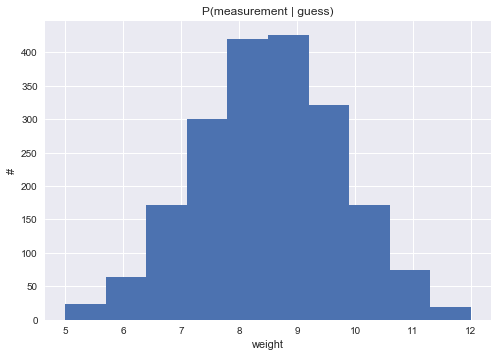

In [58]:


plt.hist([scale(Variable(torch.Tensor([8.5]))).data[0] for _ in range(2000)], range=(5.0, 12.0))
plt.title("P(measurement | guess)")
plt.xlabel("weight")
plt.ylabel("#")

So this what I think is happening. `posterior` is sampling to get an an approximate distribution of `weight`. The `marginal` uses that approximation to generate a conditional distribution. 

If I recall correctly, _importance sampling_ use one distribution that's easy to sample to explore a different distribution that's not, at least not where we're looking. Eg. looking for coins under a light post at night is our original distribution. P(spot) = chance of finding coin. our helper distribution is location of coins in the day. 

So how do we use daylight, not to change our night time distribution, but to better define it. Eg. 

Text(0,0.5,'#')

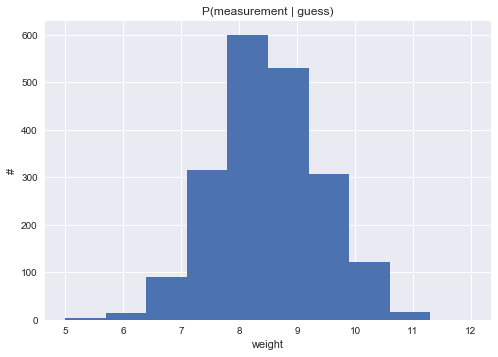

In [82]:
# we need to make a fresh marginal each time, other wise it just 
# keeps using the inferred distribution from the first sample
posterior = pyro.infer.Importance(scale, num_samples=1000)
marginal = pyro.infer.Marginal(posterior)
plt.hist([marginal(guess).data[0] for _ in range(2000)], range=(5.0, 12.0))
plt.title("P(measurement | guess)")
plt.xlabel("weight")
plt.ylabel("#")

In [83]:
posterior.guide

Text(0,0.5,'#')

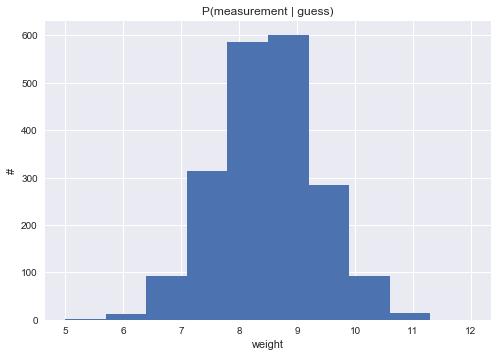

In [61]:
## Very slow ... (as expected, but more so - which makes sense -in our case the posterior is
## is sampled 100 times )

# we need to make a fresh marginal each time, other wise it just 
# keeps using the inferred distribution from the first sample
# marginal = pyro.infer.Marginal(posterior)
plt.hist([pyro.infer.Marginal(posterior)(guess).data[0] for _ in range(2000)], range=(5.0, 12.0))
plt.title("P(measurement | guess)")
plt.xlabel("weight")
plt.ylabel("#")

In [78]:
# equivalent to pyro.condition(scale, data={"measurement": Variable(torch.ones(1))})

def scale_obs1(guess):
    z = pyro.sample("weight", dist.normal, guess, Variable(torch.ones(1)))
     # here we attach an observation measurement == 1
    return pyro.sample("measurement", dist.normal, z, Variable(torch.ones(1)),
                       obs=Variable(torch.Tensor([0.1])))

# equivalent to scale_obs:
def scale_obs2(guess):
    z = pyro.sample("weight", dist.normal, guess, Variable(torch.ones(1)))
    # here we attach an observation measurement == 1
    return pyro.observe("measurement", dist.normal,
                        Variable(torch.Tensor([0.1])),
                        z, Variable(torch.ones(1)))

In [79]:
torch.manual_seed(101)
for _ in range(10):
    print(scale_obs1(Variable(torch.Tensor([8.5]))).data[0])

0.10000000149011612
0.10000000149011612
0.10000000149011612
0.10000000149011612
0.10000000149011612
0.10000000149011612
0.10000000149011612
0.10000000149011612
0.10000000149011612
0.10000000149011612


/Users/josephmann/anaconda3/envs/fst/lib/python3.6/site-packages/pyro/__init__.py:57: RuntimeWarning: trying to observe a value outside of inference at measurement
  RuntimeWarning)


In [80]:
torch.manual_seed(101)
for _ in range(10):
    print(scale_obs2(Variable(torch.Tensor([8.5]))).data[0])

0.10000000149011612
0.10000000149011612
0.10000000149011612
0.10000000149011612
0.10000000149011612
0.10000000149011612
0.10000000149011612
0.10000000149011612
0.10000000149011612
0.10000000149011612


/Users/josephmann/anaconda3/envs/fst/lib/python3.6/site-packages/pyro/__init__.py:57: RuntimeWarning: trying to observe a value outside of inference at measurement
  RuntimeWarning)


In [71]:
torch.manual_seed(101)
scale_obs1(Variable(torch.Tensor([8.5]))).data[0]

/Users/josephmann/anaconda3/envs/fst/lib/python3.6/site-packages/pyro/__init__.py:57: RuntimeWarning: trying to observe a value outside of inference at measurement
  RuntimeWarning)


0.10000000149011612

In [70]:
torch.manual_seed(101)
scale_obs2(Variable(torch.Tensor([8.5]))).data[0]

/Users/josephmann/anaconda3/envs/fst/lib/python3.6/site-packages/pyro/__init__.py:57: RuntimeWarning: trying to observe a value outside of inference at measurement
  RuntimeWarning)


1.0

In [72]:
torch.manual_seed(101)
scale_obs2(Variable(torch.Tensor([8.5]))).data[0]

/Users/josephmann/anaconda3/envs/fst/lib/python3.6/site-packages/pyro/__init__.py:57: RuntimeWarning: trying to observe a value outside of inference at measurement
  RuntimeWarning)


1.0

## this is very cool

we are inferring the actual weight (a latent variable) given the guess and the measurement!!

In [ ]:


guess = Variable(torch.Tensor([8.5]))
measurement = Variable(torch.Tensor([9.5]))

conditioned_scale = pyro.condition(scale, data={"measurement": measurement})

marginal = pyro.infer.Marginal(
    pyro.infer.Importance(conditioned_scale, num_samples=100), sites=["weight"])

# The marginal distribution concentrates around the data
print(marginal(guess))
plt.hist([marginal(guess)["weight"].data[0] for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#")